In questo notebook andrò ad esplorare 2 ulteriori possibilità per quanto riguarda la classificazione utlizzando algoritmi basati sul testo e alcune librerie di XAI (eXplainable Artificial Intellingece), nello specifico affronterò:
* classificazione usando le colonne del dataset contenenti il nome e il riassuno del film ("name", "overview")
* regressione usando le colonne del dataset contenenti il nome e il riassuno del film ("name", "overview")
* analisi del classificatore trovato nel notebook "predizione e metriche.ipynb" utilizzando:
    * [LIME](https://www.geeksforgeeks.org/artificial-intelligence/introduction-to-explainable-aixai-using-lime/)
    * [SHAP](https://www.geeksforgeeks.org/machine-learning/shap-a-comprehensive-guide-to-shapley-additive-explanations/)

### predizione sul testo

In [24]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score, 
    confusion_matrix, classification_report, 
    ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression, Ridge, ElasticNet
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# !pip install transformers
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    Trainer, 
    TrainingArguments
)
# !pip install datasets
from datasets import Dataset
# !pip install torch
import torch

dfFile = "10k_Poplar_Tv_Shows.csv"
OUTPUT_DIR = "output/text/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_STATE = 42

In [25]:
total_cores = mp.cpu_count()
n_jobs = int(total_cores * 3 / 4)
print(f"Core totali: {total_cores}")
print(f"Core utilizzati: {n_jobs}")

Core totali: 24
Core utilizzati: 18


In [26]:
# seleziono solo le colonne che mi interessano
df = pd.read_csv(dfFile)[['id','overview', 'name', 'vote_average']]
# come nell'altro dataset rimuovo le righe con id duplicati
df.drop_duplicates(subset=['id'], keep='last', inplace=True)
# rimuoviamo poi gli indici dove overview è mancante
df.dropna(subset=['overview'], inplace=True)
# e la colonna id che non ci serve
df.drop("id", axis=1, inplace=True)

In [27]:
# controlliamo che non ci siano indici mancanti
missing_values = df.isnull().sum()
for col, row in missing_values.items():
    print (col, row)

overview 0
name 0
vote_average 0


In [28]:
# uniamo poi il nome e la colonna overview
df['overview'] = df['name'] + ' ' + df['overview']
# e droppiamo anche la colonna name
df.drop("name", axis=1, inplace=True)

In [29]:
# facciamo diventare il dataset pronto per la categorizzazione 
df['vote_average_classification'] = df['vote_average'].round().astype(int)

In [30]:
# split
X = df['overview']
y_class = df['vote_average_classification']
y_reg = df['vote_average']

# Split per modelli tradizionali
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, random_state=RANDOM_STATE, stratify=y_class
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

In [31]:
X_train_distil = X_train
y_class_train_distil = y_class_train
X_train_distil_reg = X_train
y_reg_train_distil = y_reg_train

In [32]:
classification_param_grids = {
    'Logistic Regression': {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['lbfgs']
    },
    
    'Naive Bayes': {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'classifier__alpha': [0.1, 1.0]
    },
    
    'Random Forest': {
        'tfidf__max_features': [5000],
        'tfidf__ngram_range': [(1, 2)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    },
}

In [33]:
# training classificatori
outputFileName = os.path.join(OUTPUT_DIR, "classification_results.pkl")

if not os.path.isfile(outputFileName):
    print("TRAINING CLASSIFICATORI")
    
    classification_results = []
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=n_jobs),
        'Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=n_jobs),
    }
    
    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"Training: {model_name}")
        print(f"{'='*80}")
        
        # Pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', min_df=2)),
            ('classifier', model)
        ])
        
        # GridSearch
        grid_search = GridSearchCV(
            pipeline,
            classification_param_grids[model_name],
            cv=5,
            scoring='accuracy',
            n_jobs=n_jobs,
            verbose=1
        )
        
        # Training
        print(f"Inizio training...")
        grid_search.fit(X_train, y_class_train)
        
        # Migliori parametri
        print(f"\nMigliori parametri:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"CV Score: {grid_search.best_score_:.4f}")
        
        # Predizioni
        y_pred = grid_search.predict(X_test)
        
        # Metriche
        accuracy = accuracy_score(y_class_test, y_pred)
        precision = precision_score(y_class_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_class_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_class_test, y_pred, average='weighted', zero_division=0)
        
        print(f"\nRisultati Test Set:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        
        classification_results.append({
            'model_name': model_name,
            'best_model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred
        })
    
    # Salva risultati
    with open(outputFileName, 'wb') as f:
        pickle.dump(classification_results, f)

with open(outputFileName, 'rb') as f:
    classification_results = pickle.load(f)

In [34]:
print("RIEPILOGO CLASSIFICAZIONE")
classification_results_sorted = sorted(classification_results, key=lambda x: x['accuracy'], reverse=True)

for r in classification_results_sorted:
    print(f"{r['model_name']:<25} {r['accuracy']:<12.4f} {r['f1_score']:<12.4f} {r['cv_score']:<12.4f}")

print(f"\nMiglior modello: {classification_results_sorted[0]['model_name']}")
print(f"   Accuracy: {classification_results_sorted[0]['accuracy']:.4f}")


RIEPILOGO CLASSIFICAZIONE
Naive Bayes               0.4095       0.3624       0.3772      
Logistic Regression       0.3914       0.3375       0.3696      
Random Forest             0.3851       0.2740       0.3753      

Miglior modello: Naive Bayes
   Accuracy: 0.4095


In [35]:
regression_param_grids = {
    'Ridge': {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    
    'ElasticNet': {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'regressor__alpha': [0.1, 1.0],
        'regressor__l1_ratio': [0.5]
    },
    
    'Random Forest Regressor': {
        'tfidf__max_features': [5000],
        'tfidf__ngram_range': [(1, 2)],
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20]
    }
}

In [36]:
# Training regressori
outputFileName = os.path.join(OUTPUT_DIR, "regression_results.pkl")

if not os.path.isfile(outputFileName):
    print("TRAINING REGRESSORI")
    
    regression_results = []
    
    models = {
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'ElasticNet': ElasticNet(random_state=RANDOM_STATE, max_iter=2000),
        'Random Forest Regressor': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=n_jobs)
    }
    
    for model_name, model in models.items():
        print(f"Training: {model_name}")
        
        # Pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', min_df=2)),
            ('regressor', model)
        ])
        
        # GridSearch
        grid_search = GridSearchCV(
            pipeline,
            regression_param_grids[model_name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=n_jobs,
            verbose=1
        )
        
        # Training
        print(f"Inizio training...")
        grid_search.fit(X_train, y_reg_train)
        
        # Migliori parametri
        print(f"\nMigliori parametri:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"CV Score (neg_MSE): {grid_search.best_score_:.4f}")
        
        # Predizioni
        y_pred = grid_search.predict(X_test)
        
        # Metriche
        mse = mean_squared_error(y_reg_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_reg_test, y_pred)
        r2 = r2_score(y_reg_test, y_pred)
        
        print(f"\nRisultati Test Set:")
        print(f"  MSE:   {mse:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  MAE:   {mae:.4f}")
        print(f"  R²:    {r2:.4f}")
        
        regression_results.append({
            'model_name': model_name,
            'best_model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'cv_score': -grid_search.best_score_,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred
        })
    
    # Salva risultati
    with open(outputFileName, 'wb') as f:
        pickle.dump(regression_results, f)

with open(outputFileName, 'rb') as f:
    regression_results = pickle.load(f)

In [37]:
print("RIEPILOGO REGRESSIONE")
regression_results_sorted = sorted(regression_results, key=lambda x: x['rmse'])

for r in regression_results_sorted:
    print(f"{r['model_name']:<25} {r['rmse']:<12.4f} {r['mae']:<12.4f} {r['r2']:<12.4f}")

print(f"\nMiglior modello: {regression_results_sorted[0]['model_name']}")
print(f"   RMSE: {regression_results_sorted[0]['rmse']:.4f}")

RIEPILOGO REGRESSIONE
ElasticNet                2.0474       1.3296       -0.0001     
Random Forest Regressor   2.0523       1.3321       -0.0049     
Ridge                     2.0599       1.3430       -0.0123     

Miglior modello: ElasticNet
   RMSE: 2.0474


In [38]:
print("PREPARAZIONE DATI PER DISTILBERT")
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    """Tokenizza i testi per DistilBERT"""
    return tokenizer(
        examples['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=128
    )

# Prepara dataset per classificazione
train_dataset_class = Dataset.from_dict({
    'text': X_train_distil.tolist(),
    'label': y_class_train_distil.tolist()
})

test_dataset_class = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_class_test.tolist()
})

# Tokenizza
train_dataset_class = train_dataset_class.map(tokenize_function, batched=True)
test_dataset_class = test_dataset_class.map(tokenize_function, batched=True)

# Prepara dataset per regressione
train_dataset_reg = Dataset.from_dict({
    'text': X_train_distil_reg.tolist(),
    'label': y_reg_train_distil.tolist()
})

test_dataset_reg = Dataset.from_dict({
    'text': X_test.tolist(),
    'label': y_reg_test.tolist()
})

# Tokenizza
train_dataset_reg = train_dataset_reg.map(tokenize_function, batched=True)
test_dataset_reg = test_dataset_reg.map(tokenize_function, batched=True)

print("Dataset tokenizzati")
print(f"  Train classification: {len(train_dataset_class)} samples")
print(f"  Test classification: {len(test_dataset_class)} samples")
print(f"  Train regression: {len(train_dataset_reg)} samples")
print(f"  Test regression: {len(test_dataset_reg)} samples")

PREPARAZIONE DATI PER DISTILBERT


Map:   0%|          | 0/7050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1763 [00:00<?, ? examples/s]

Map:   0%|          | 0/7050 [00:00<?, ? examples/s]

Map:   0%|          | 0/1763 [00:00<?, ? examples/s]

Dataset tokenizzati
  Train classification: 7050 samples
  Test classification: 1763 samples
  Train regression: 7050 samples
  Test regression: 1763 samples


In [39]:
# Training DistilBERT
outputFileName = os.path.join(OUTPUT_DIR, "distilbert_classification_results.pkl")

if not os.path.isfile(outputFileName):
    print("TRAINING DISTILBERT - CLASSIFICAZIONE")
    
    # Numero di classi
    num_labels = len(y_class.unique())
    print(f"Numero di classi: {num_labels}")
    
    # Modello
    model_class = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=num_labels
    )
    
    # Training arguments - ottimizzati per velocità
    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, 'distilbert_class_checkpoints'),
        num_train_epochs=2,  # Poche epoche per velocità
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=os.path.join(OUTPUT_DIR, 'logs'),
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=torch.cuda.is_available(),  # Usa mixed precision se GPU disponibile
    )
    
    # Metric computation
    def compute_metrics_class(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        return {'accuracy': accuracy, 'f1': f1}
    
    # Trainer
    trainer = Trainer(
        model=model_class,
        args=training_args,
        train_dataset=train_dataset_class,
        eval_dataset=test_dataset_class,
        compute_metrics=compute_metrics_class
    )
    
    # Training
    print("Inizio training DistilBERT")
    trainer.train()
    
    # Valutazione
    print("\nValutazione su test set")
    eval_results = trainer.evaluate()
    
    # Predizioni
    predictions = trainer.predict(test_dataset_class)
    y_pred_distil = np.argmax(predictions.predictions, axis=-1)
    
    # Metriche
    accuracy = accuracy_score(y_class_test, y_pred_distil)
    precision = precision_score(y_class_test, y_pred_distil, average='weighted', zero_division=0)
    recall = recall_score(y_class_test, y_pred_distil, average='weighted', zero_division=0)
    f1 = f1_score(y_class_test, y_pred_distil, average='weighted', zero_division=0)
    
    print(f"\nRisultati Test Set:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    distilbert_class_results = {
        'model_name': 'DistilBERT Classification',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred_distil,
        'eval_results': eval_results
    }
    
    # Salva risultati
    with open(outputFileName, 'wb') as f:
        pickle.dump(distilbert_class_results, f)
    
    # Salva anche il modello
    model_save_path = os.path.join(OUTPUT_DIR, 'distilbert_classifier')
    trainer.save_model(model_save_path)

with open(outputFileName, 'rb') as f:
    distilbert_class_results = pickle.load(f)

In [40]:
print("RISULTATI DISTILBERT - CLASSIFICAZIONE")
print(f"Accuracy:  {distilbert_class_results['accuracy']:.4f}")
print(f"Precision: {distilbert_class_results['precision']:.4f}")
print(f"Recall:    {distilbert_class_results['recall']:.4f}")
print(f"F1-Score:  {distilbert_class_results['f1_score']:.4f}")

RISULTATI DISTILBERT - CLASSIFICAZIONE
Accuracy:  0.4169
Precision: 0.3531
Recall:    0.4169
F1-Score:  0.3802


In [41]:
# confronto fra modelli trainati
OUTPUT_DIR = "output/text/"

with open(os.path.join(OUTPUT_DIR, "classification_results.pkl"), 'rb') as f:
    classification_results = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "regression_results.pkl"), 'rb') as f:
    regression_results = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "distilbert_classification_results.pkl"), 'rb') as f:
    distilbert_class_results = pickle.load(f)

In [42]:
# DataFrame per confronto classificatori
classification_comparison = []

for r in classification_results:
    classification_comparison.append({
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'CV Score': r['cv_score']
    })

classification_comparison.append({
    'Model': 'DistilBERT',
    'Accuracy': distilbert_class_results['accuracy'],
    'Precision': distilbert_class_results['precision'],
    'Recall': distilbert_class_results['recall'],
    'F1-Score': distilbert_class_results['f1_score'],
    'CV Score': None  # DistilBERT non ha CV score nello stesso formato
})

df_class_comp = pd.DataFrame(classification_comparison)
df_class_comp = df_class_comp.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("CONFRONTO CLASSIFICATORI")
print(df_class_comp.to_string(index=False))

CONFRONTO CLASSIFICATORI
              Model  Accuracy  Precision   Recall  F1-Score  CV Score
         DistilBERT  0.416903   0.353058 0.416903  0.380227       NaN
        Naive Bayes  0.409529   0.346406 0.409529  0.362445  0.377163
Logistic Regression  0.391378   0.343793 0.391378  0.337492  0.369645
      Random Forest  0.385139   0.327620 0.385139  0.273994  0.375319


In [43]:
best_classifier = df_class_comp.iloc[0]['Model']
print(f"MIGLIOR CLASSIFICATORE: {best_classifier}")
print(f"   Accuracy: {df_class_comp.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {df_class_comp.iloc[0]['F1-Score']:.4f}")

MIGLIOR CLASSIFICATORE: DistilBERT
   Accuracy: 0.4169
   F1-Score: 0.3802


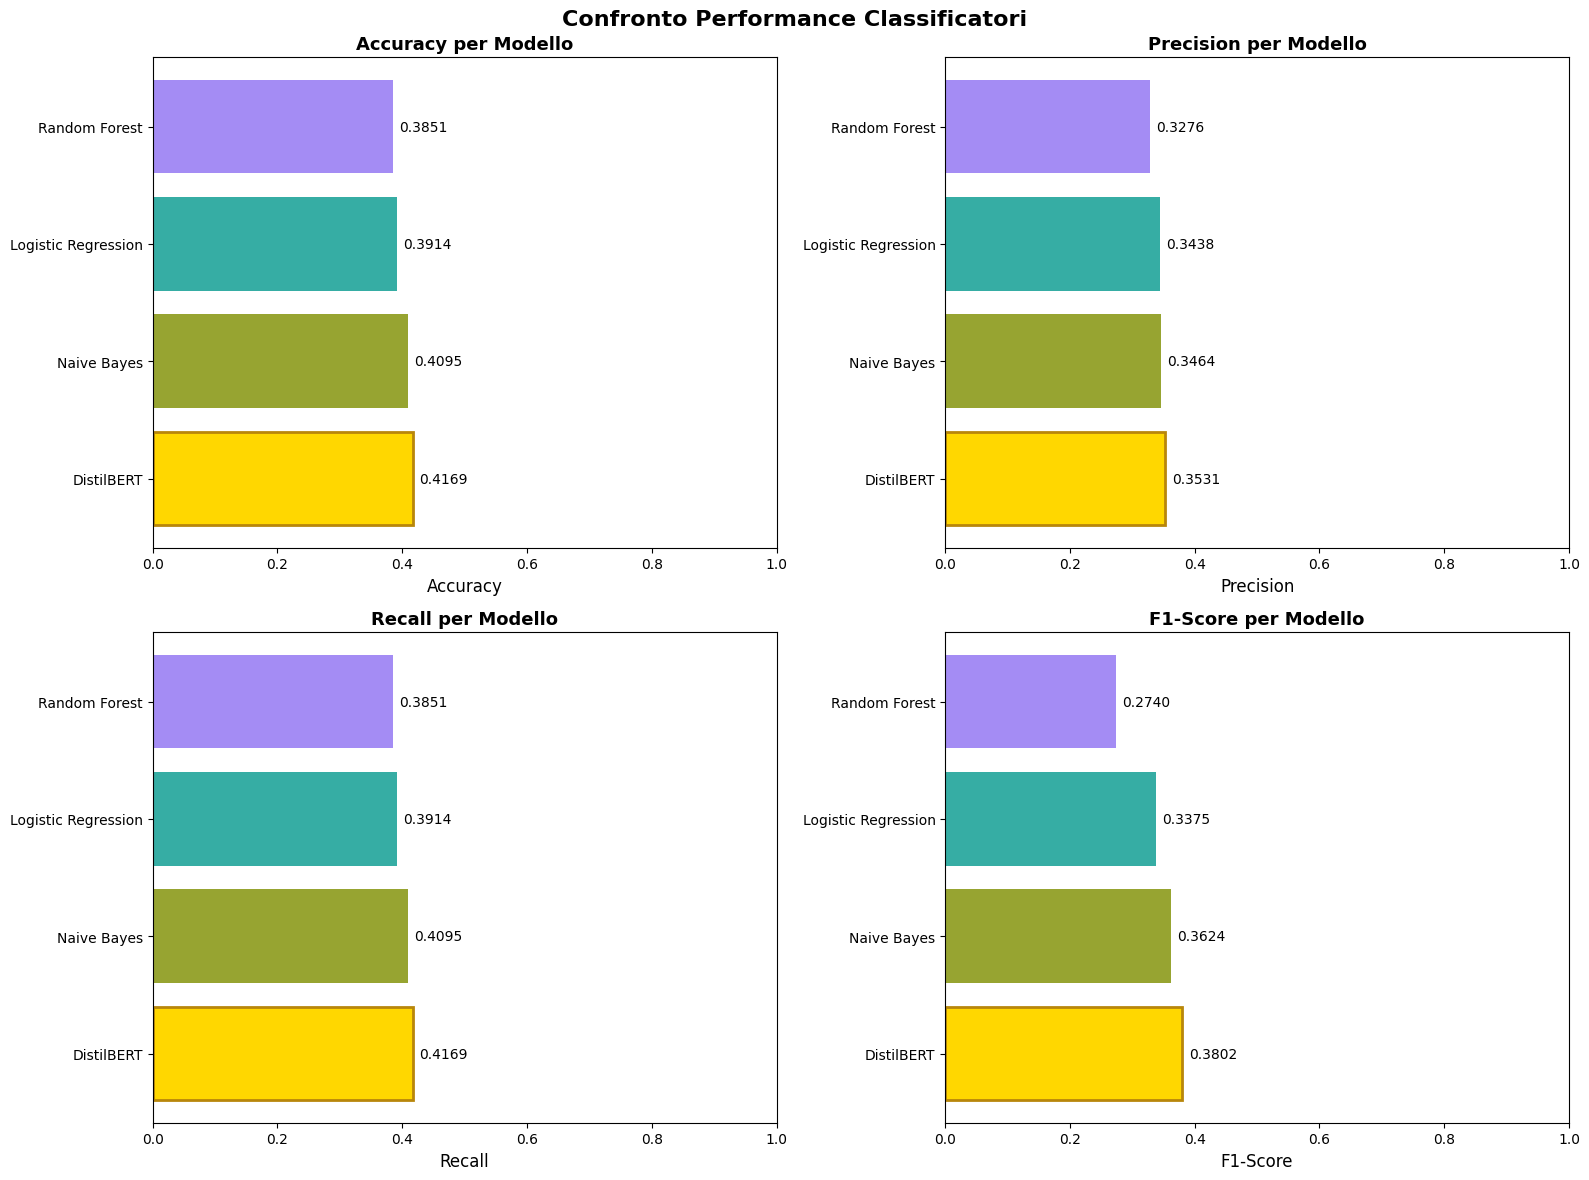

In [44]:
# Visualizzazione confronto classificatori
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confronto Performance Classificatori', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = sns.color_palette("husl", len(df_class_comp))

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    bars = ax.barh(df_class_comp['Model'], df_class_comp[metric], color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} per Modello', fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1])
    
    for i, (bar, value) in enumerate(zip(bars, df_class_comp[metric])):
        ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center', fontsize=10)
    
    max_idx = df_class_comp[metric].idxmax()
    bars[max_idx].set_color('gold')
    bars[max_idx].set_edgecolor('darkgoldenrod')
    bars[max_idx].set_linewidth(2)

plt.tight_layout()
plt.show()

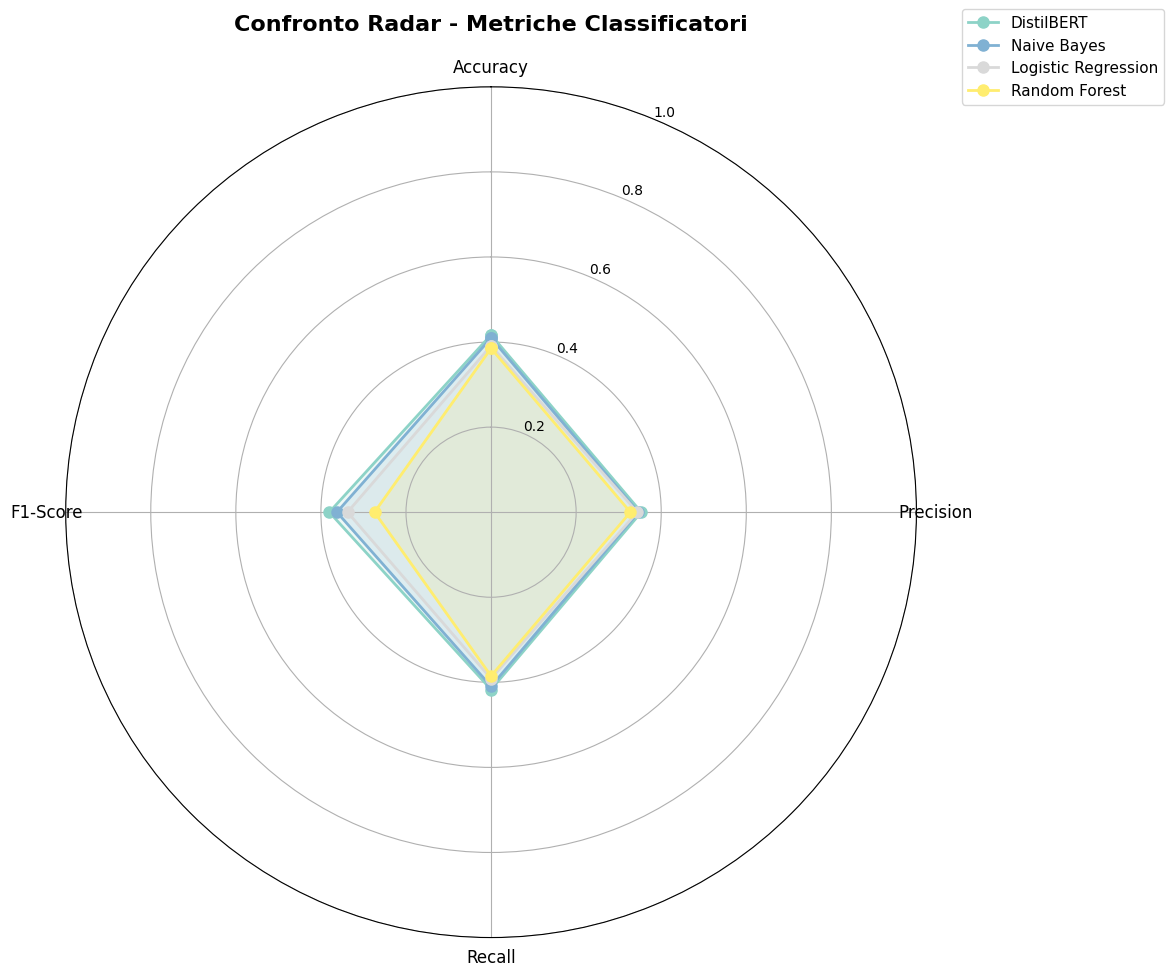

In [45]:
# Grafico radar per confronto multidimensionale
from math import pi

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)

# Plotta ogni modello
colors_radar = plt.cm.Set3(np.linspace(0, 1, len(df_class_comp)))

for idx, row in df_class_comp.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], 
            color=colors_radar[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_ylim(0, 1)
ax.set_title('Confronto Radar - Metriche Classificatori', 
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

In [46]:
# DataFrame per confronto regressori
regression_comparison = []

for r in regression_results:
    regression_comparison.append({
        'Model': r['model_name'],
        'RMSE': r['rmse'],
        'MAE': r['mae'],
        'R²': r['r2'],
        'MSE': r['mse'],
        'CV Score (MSE)': r['cv_score']
    })

df_reg_comp = pd.DataFrame(regression_comparison)
df_reg_comp = df_reg_comp.sort_values('RMSE').reset_index(drop=True)

print("CONFRONTO REGRESSORI")
print(df_reg_comp.to_string(index=False))
print("\n")

# Identifica il miglior modello
best_regressor = df_reg_comp.iloc[0]['Model']
print(f"MIGLIOR REGRESSORE: {best_regressor}")
print(f"   RMSE: {df_reg_comp.iloc[0]['RMSE']:.4f}")
print(f"   R²:   {df_reg_comp.iloc[0]['R²']:.4f}")

CONFRONTO REGRESSORI
                  Model     RMSE      MAE        R²      MSE  CV Score (MSE)
             ElasticNet 2.047437 1.329581 -0.000080 4.191999        4.009776
Random Forest Regressor 2.052328 1.332148 -0.004864 4.212052        4.028586
                  Ridge 2.059879 1.343030 -0.012271 4.243100        4.060491


MIGLIOR REGRESSORE: ElasticNet
   RMSE: 2.0474
   R²:   -0.0001


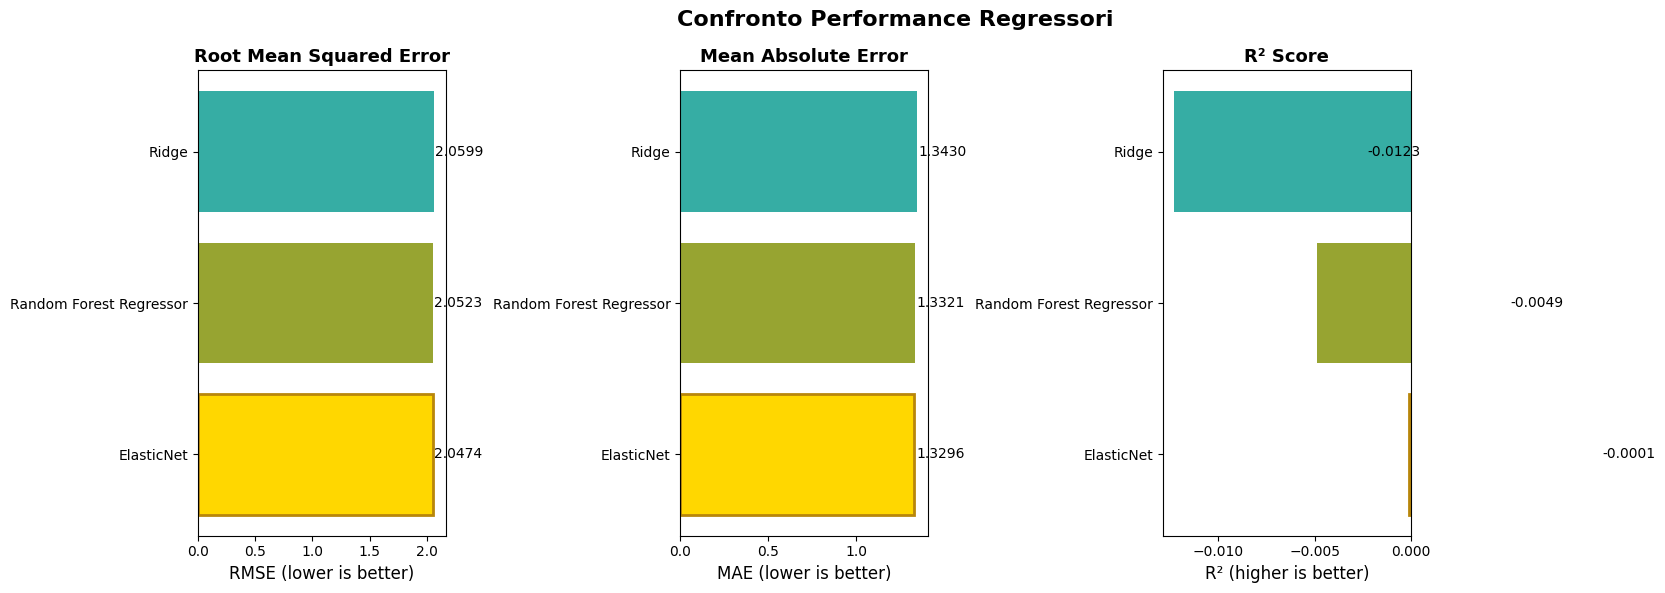

In [47]:
# Plot confronto regressori
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Confronto Performance Regressori', fontsize=16, fontweight='bold')

# RMSE
ax1 = axes[0]
bars1 = ax1.barh(df_reg_comp['Model'], df_reg_comp['RMSE'], color=colors[:len(df_reg_comp)])
ax1.set_xlabel('RMSE (lower is better)', fontsize=12)
ax1.set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
for bar, value in zip(bars1, df_reg_comp['RMSE']):
    ax1.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', va='center', fontsize=10)
bars1[0].set_color('gold')
bars1[0].set_edgecolor('darkgoldenrod')
bars1[0].set_linewidth(2)

# MAE
ax2 = axes[1]
bars2 = ax2.barh(df_reg_comp['Model'], df_reg_comp['MAE'], color=colors[:len(df_reg_comp)])
ax2.set_xlabel('MAE (lower is better)', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
for bar, value in zip(bars2, df_reg_comp['MAE']):
    ax2.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', va='center', fontsize=10)
bars2[df_reg_comp['MAE'].idxmin()].set_color('gold')
bars2[df_reg_comp['MAE'].idxmin()].set_edgecolor('darkgoldenrod')
bars2[df_reg_comp['MAE'].idxmin()].set_linewidth(2)

# R²
ax3 = axes[2]
bars3 = ax3.barh(df_reg_comp['Model'], df_reg_comp['R²'], color=colors[:len(df_reg_comp)])
ax3.set_xlabel('R² (higher is better)', fontsize=12)
ax3.set_title('R² Score', fontsize=13, fontweight='bold')
for bar, value in zip(bars3, df_reg_comp['R²']):
    ax3.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.4f}', va='center', fontsize=10)
bars3[df_reg_comp['R²'].idxmax()].set_color('gold')
bars3[df_reg_comp['R²'].idxmax()].set_edgecolor('darkgoldenrod')
bars3[df_reg_comp['R²'].idxmax()].set_linewidth(2)

plt.tight_layout()
plt.show()

In [48]:
# Trova il miglior classificatore e le sue predizioni
best_class_idx = df_class_comp['Accuracy'].idxmax()
best_class_name = df_class_comp.iloc[best_class_idx]['Model']

# Recupera le predizioni
if best_class_name == 'DistilBERT':
    y_pred_best = distilbert_class_results['predictions']
else:
    for r in classification_results:
        if r['model_name'] == best_class_name:
            y_pred_best = r['predictions']
            best_model_obj = r['best_model']
            best_params = r['best_params']
            break

# Carica le etichette di test
dfFile = "10k_Poplar_Tv_Shows.csv"
df = pd.read_csv(dfFile)[['id','overview', 'name', 'vote_average']]
df.drop_duplicates(subset=['id'], keep='last', inplace=True)
df.dropna(subset=['overview'], inplace=True)
df.drop("id", axis=1, inplace=True)
df['overview'] = df['name'] + ' ' + df['overview']
df.drop("name", axis=1, inplace=True)
df['vote_average_classification'] = df['vote_average'].round().astype(int)

X = df['overview']
y_class = df['vote_average_classification']

X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"\n{'='*80}")
print(f"ANALISI DETTAGLIATA: {best_class_name}")
print(f"{'='*80}\n")

if best_class_name != 'DistilBERT':
    print("Migliori parametri trovati:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print()

# Classification Report
print("Classification Report:")
print(classification_report(y_class_test, y_pred_best, zero_division=0))


ANALISI DETTAGLIATA: DistilBERT

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.34      0.36        95
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        73
           6       0.30      0.33      0.31       266
           7       0.42      0.43      0.42       519
           8       0.46      0.63      0.53       630
           9       0.00      0.00      0.00        87
          10       0.00      0.00      0.00        33

    accuracy                           0.42      1763
   macro avg       0.14      0.16      0.15      1763
weighted avg       0.35      0.42      0.38      1763



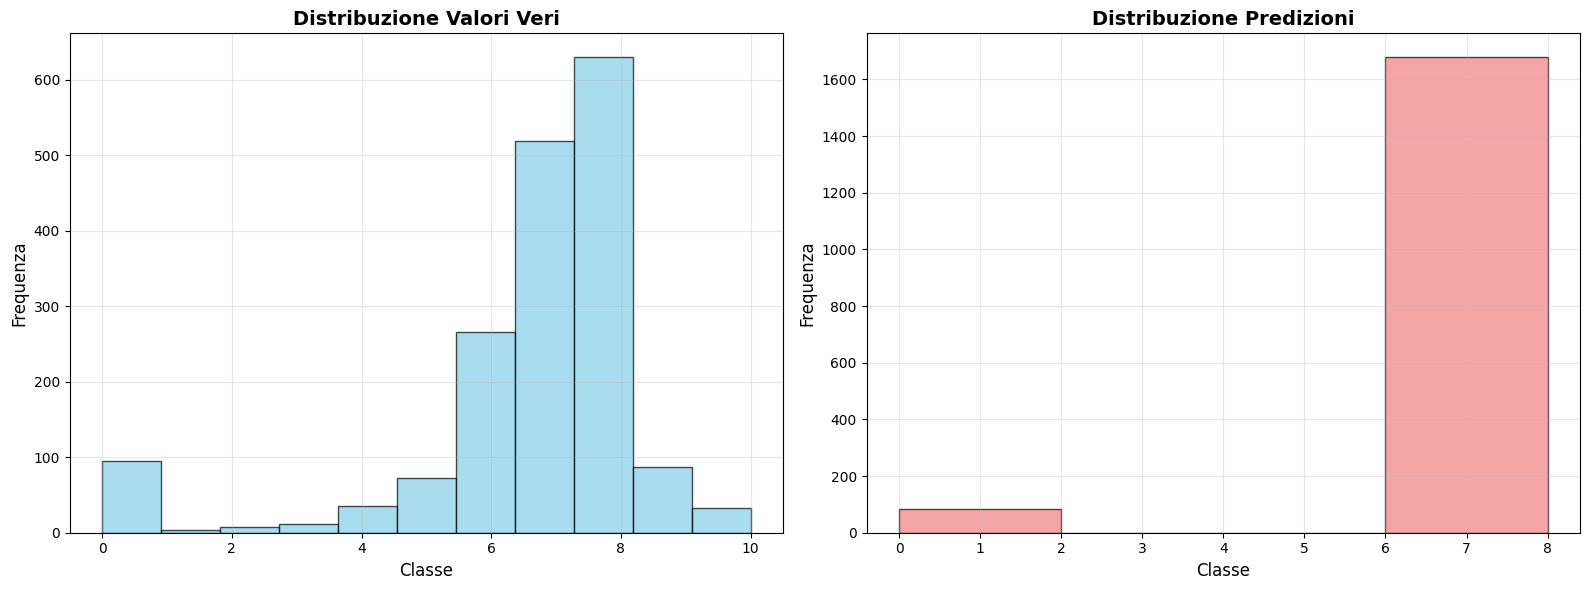

In [50]:
# Distribuzione delle predizioni vs veri valori
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribuzione valori veri
axes[0].hist(y_class_test, bins=len(y_class_test.unique()), 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuzione Valori Veri', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].set_ylabel('Frequenza', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Distribuzione predizioni
axes[1].hist(y_pred_best, bins=len(np.unique(y_pred_best)), 
             color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribuzione Predizioni', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe', fontsize=12)
axes[1].set_ylabel('Frequenza', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
# Trova il miglior regressore
best_reg_name = df_reg_comp.iloc[0]['Model']

for r in regression_results:
    if r['model_name'] == best_reg_name:
        y_pred_reg_best = r['predictions']
        best_model_reg = r['best_model']
        best_params_reg = r['best_params']
        break

# Carica i valori di test per regressione
y_reg = df['vote_average']
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

print(f"ANALISI DETTAGLIATA: {best_reg_name}")

print("Migliori parametri trovati:")
for param, value in best_params_reg.items():
    print(f"  {param}: {value}")
print()

# Statistiche
residuals = y_reg_test - y_pred_reg_best
print("Statistiche Residui:")
print(f"  Media:     {np.mean(residuals):.4f}")
print(f"  Std Dev:   {np.std(residuals):.4f}")
print(f"  Min:       {np.min(residuals):.4f}")
print(f"  Max:       {np.max(residuals):.4f}")

ANALISI DETTAGLIATA: ElasticNet
Migliori parametri trovati:
  regressor__alpha: 0.1
  regressor__l1_ratio: 0.5
  tfidf__max_features: 5000
  tfidf__ngram_range: (1, 1)

Statistiche Residui:
  Media:     -0.0183
  Std Dev:   2.0474
  Min:       -6.7812
  Max:       3.2188


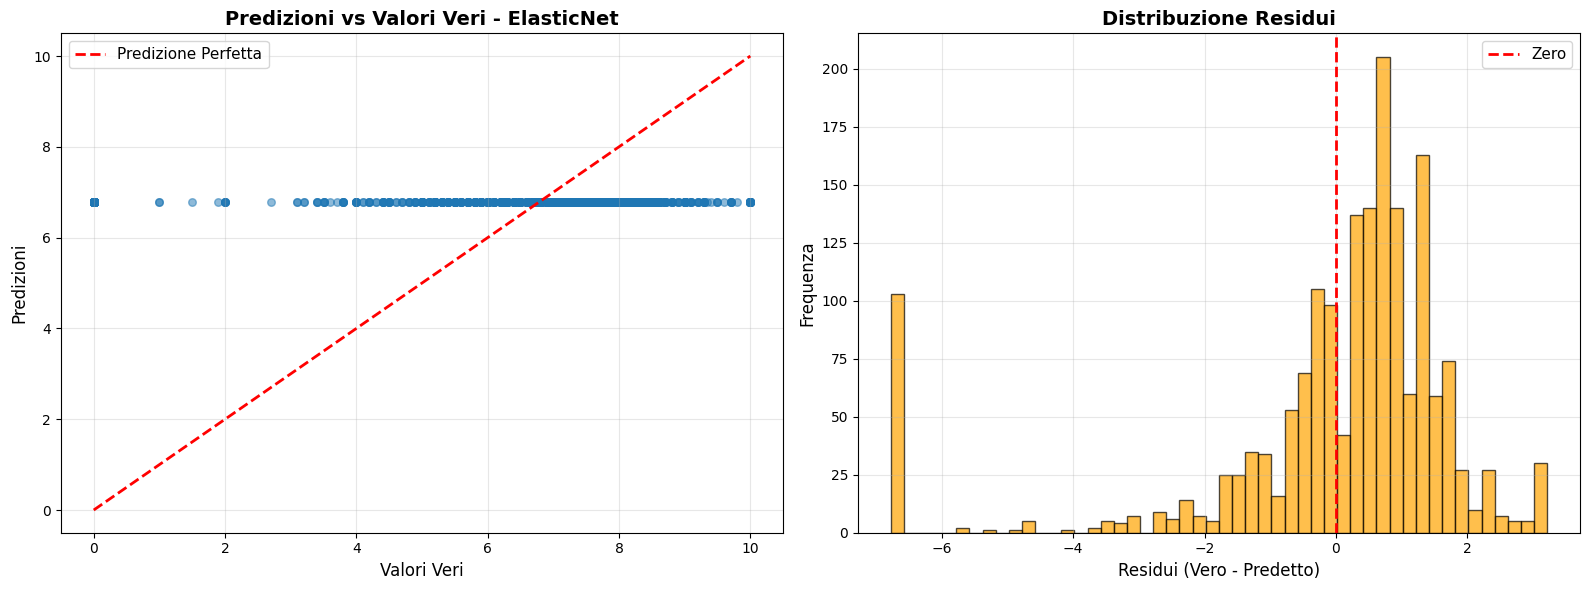

In [52]:
# Scatter plot: Predizioni vs Ground truth
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_reg_test, y_pred_reg_best, alpha=0.5, s=30)
axes[0].plot([y_reg_test.min(), y_reg_test.max()], 
             [y_reg_test.min(), y_reg_test.max()], 
             'r--', lw=2, label='Predizione Perfetta')
axes[0].set_xlabel('Valori Veri', fontsize=12)
axes[0].set_ylabel('Predizioni', fontsize=12)
axes[0].set_title(f'Predizioni vs Valori Veri - {best_reg_name}', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Distribuzione residui
axes[1].hist(residuals, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_xlabel('Residui (Vero - Predetto)', fontsize=12)
axes[1].set_ylabel('Frequenza', fontsize=12)
axes[1].set_title('Distribuzione Residui', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
print("RIEPILOGO FINALE - MIGLIORI MODELLI")

print("CLASSIFICAZIONE:")
print(f"   Modello: {best_class_name}")
print(f"   Accuracy:  {df_class_comp.iloc[0]['Accuracy']:.4f}")
print(f"   Precision: {df_class_comp.iloc[0]['Precision']:.4f}")
print(f"   Recall:    {df_class_comp.iloc[0]['Recall']:.4f}")
print(f"   F1-Score:  {df_class_comp.iloc[0]['F1-Score']:.4f}")

print("\nREGRESSIONE:")
print(f"   Modello: {best_reg_name}")
print(f"   RMSE: {df_reg_comp.iloc[0]['RMSE']:.4f}")
print(f"   MAE:  {df_reg_comp.iloc[0]['MAE']:.4f}")
print(f"   R²:   {df_reg_comp.iloc[0]['R²']:.4f}")

RIEPILOGO FINALE - MIGLIORI MODELLI
CLASSIFICAZIONE:
   Modello: DistilBERT
   Accuracy:  0.4169
   Precision: 0.3531
   Recall:    0.4169
   F1-Score:  0.3802

REGRESSIONE:
   Modello: ElasticNet
   RMSE: 2.0474
   MAE:  1.3296
   R²:   -0.0001


### explainability

per il blocco di explainability prenderò il classificatore che ho identificato come migliore ed effettuerò una speigazione dell'istanza media di ogni classe per capire come che regola viene seguita dal classificatore per arrivare alla predizione

userò 2 liberie in particolare:
* [LIME](https://www.geeksforgeeks.org/artificial-intelligence/introduction-to-explainable-aixai-using-lime/)
* [SHAP](https://www.geeksforgeeks.org/machine-learning/shap-a-comprehensive-guide-to-shapley-additive-explanations/)

In [54]:
import os
from io import StringIO
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install lime
import lime
import lime.lime_tabular
# !pip install shap
import shap
# !pip install lightgbm
import lightgbm as lgb

dfClassImBalancedFile = "data/df_clean_encoded_train_no_outliers_scaled_classification.csv"
dfClassTestFile = "data/df_clean_encoded_test_classification.csv"

TARGET_COL = 'vote_average'

In [55]:
dfTrain = pd.read_csv(dfClassImBalancedFile)
dfTest = pd.read_csv(dfClassTestFile)

X_train = dfTrain.drop(columns=[TARGET_COL])
y_train = dfTrain[TARGET_COL]

X_test = dfTest.drop(columns=[TARGET_COL])
y_test = dfTest[TARGET_COL]

clf = lgb.LGBMClassifier(learning_rate=0.015, max_depth=10, n_estimators=250, num_leaves=70, random_state=42, verbose=-1)
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.015, max_depth=10, n_estimators=250,
               num_leaves=70, random_state=42, verbose=-1)

In [56]:
def find_class_centroids(dfTest, target_col=TARGET_COL):
    """
    Find the centroid (mean) of each class in the test dataset.
    """
    centroids = []
    
    # Get unique classes and sort them
    classes = sorted(dfTest[target_col].unique())
    
    # Extract features (all columns except target)
    feature_cols = [col for col in dfTest.columns if col != target_col]
    
    for class_val in classes:
        # Filter instances of this class
        class_instances = dfTest[dfTest[target_col] == class_val][feature_cols]
        
        # Calculate centroid (mean of all instances)
        centroid = class_instances.mean().values
        
        centroids.append((class_val, centroid))
    
    return centroids

In [57]:
def explain_centroids(centroids, clf, dfTrain, target_col=TARGET_COL):
    """
    Explain each centroid using LIME and SHAP.
    Saves textual output and plots to output/xai/<class>/ folders.
    """
    
    # Create base output directory
    base_output_dir = "output/xai"
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Prepare data
    feature_cols = [col for col in dfTrain.columns if col != target_col]
    X_train = dfTrain[feature_cols].values

    # Initialize LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_cols,
        class_names=[str(c) for c in sorted(dfTrain[target_col].unique())],
        mode='classification',
        random_state=42
    )

    # Initialize SHAP explainer
    try:
        # Try TreeExplainer first (faster for tree-based models)
        shap_explainer = shap.TreeExplainer(clf)
    except:
        # Fallback to KernelExplainer for other models
        shap_explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X_train, 100))

    # Explain each centroid
    for class_val, centroid in centroids:
        # Create class-specific output directory
        class_output_dir = os.path.join(base_output_dir, f"class_{class_val}")
        os.makedirs(class_output_dir, exist_ok=True)
        
        # Capture textual output
        text_output = StringIO()
        
        # Helper function to print and save
        def print_and_save(text):
            print(text)
            text_output.write(text + "\n")
        
        print_and_save("=" * 80)
        print_and_save(f"EXPLAINING CLASS: {class_val}")
        print_and_save("=" * 80)
        
        # Get prediction for centroid
        centroid_2d = centroid.reshape(1, -1)
        prediction = clf.predict(centroid_2d)[0]
        proba = clf.predict_proba(centroid_2d)[0]
        
        print_and_save(f"\nCentroid Prediction: {prediction}")
        print_and_save(f"Prediction Probabilities: {proba}")
        print_and_save(f"Predicted Class Probability: {proba[int(prediction)]:.4f}\n")
        
        # ==================== LIME EXPLANATION ====================
        lime_exp = lime_explainer.explain_instance(
            centroid,
            clf.predict_proba,
            num_features=len(feature_cols)
        )
        
        # ==================== SHAP EXPLANATION ====================
        shap_values = shap_explainer.shap_values(centroid_2d)
        
        # Handle different SHAP output formats
        if isinstance(shap_values, list):
            # Multi-class: use values for predicted class
            shap_values_for_pred = shap_values[int(prediction)]
        else:
            # Binary or single output
            shap_values_for_pred = shap_values
        
        # Ensure it's 1D array
        if len(shap_values_for_pred.shape) == 2:
            shap_vals = shap_values_for_pred[0]
        else:
            shap_vals = shap_values_for_pred
            
        # Make sure it's truly 1D
        shap_vals = np.array(shap_vals).flatten()
        
        # **FIX: Ensure shap_vals matches the number of features**
        if len(shap_vals) != len(feature_cols):
            warning_msg = f"Warning: SHAP values length ({len(shap_vals)}) doesn't match features ({len(feature_cols)})"
            print_and_save(warning_msg)
            # Take only the first n values matching feature count
            shap_vals = shap_vals[:len(feature_cols)]
        
        # ==================== FEATURE IMPORTANCE ====================
        print_and_save("\n" + "-" * 40)
        print_and_save("LIME FEATURE IMPORTANCE (Top 10)")
        print_and_save("-" * 40)
        lime_weights = lime_exp.as_list()
        for feature, weight in lime_weights[:10]:
            print_and_save(f"{feature:30s}: {weight:+.6f}")
        
        print_and_save("\n" + "-" * 40)
        print_and_save("SHAP FEATURE IMPORTANCE (Top 10)")
        print_and_save("-" * 40)
        
        feature_importance = list(zip(feature_cols, shap_vals))
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
        for feature, value in feature_importance[:10]:
            # Convert to float to ensure it's a scalar
            val = float(value) if hasattr(value, '__float__') else value
            print_and_save(f"{feature:30s}: {val:+.6f}")
        
        # Save textual output to file
        txt_filename = os.path.join(class_output_dir, "explanation.txt")
        with open(txt_filename, 'w') as f:
            f.write(text_output.getvalue())
        
        # ==================== INDIVIDUAL PLOTS ====================
        
        # Plot 1: LIME Bar Plot (Top 10)
        fig1 = plt.figure(figsize=(10, 8))
        lime_data = lime_exp.as_list()[:10]
        features = [x[0] for x in lime_data]
        weights = [x[1] for x in lime_data]
        colors = ['green' if w > 0 else 'red' for w in weights]
        plt.barh(range(len(features)), weights, color=colors)
        plt.yticks(range(len(features)), features)
        plt.xlabel('Weight', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'LIME Feature Importance (Top 10) - Class {class_val}', fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plot1_filename = os.path.join(class_output_dir, "01_lime_top10.png")
        plt.savefig(plot1_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        # Plot 2: SHAP Bar Plot (Top 10)
        fig2 = plt.figure(figsize=(10, 8))
        top_k = min(10, len(shap_vals))
        top_indices = np.argsort(np.abs(shap_vals))[-top_k:]
        plt.barh(
            range(len(top_indices)),
            shap_vals[top_indices],
            color=['green' if v > 0 else 'red' for v in shap_vals[top_indices]]
        )
        plt.yticks(range(len(top_indices)), [feature_cols[i] for i in top_indices])
        plt.xlabel('SHAP Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'SHAP Feature Importance (Top {top_k}) - Class {class_val}', fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plot2_filename = os.path.join(class_output_dir, "02_shap_top10.png")
        plt.savefig(plot2_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        # Plot 3: LIME with all features
        fig3 = plt.figure(figsize=(12, max(10, len(feature_cols) * 0.3)))
        all_lime_data = lime_exp.as_list()
        features_all = [x[0][:50] for x in all_lime_data]  # Truncate long names
        weights_all = [x[1] for x in all_lime_data]
        colors_all = ['green' if w > 0 else 'red' for w in weights_all]
        plt.barh(range(len(features_all)), weights_all, color=colors_all)
        plt.yticks(range(len(features_all)), features_all, fontsize=9)
        plt.xlabel('Weight', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'LIME All Features - Class {class_val}', fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plot3_filename = os.path.join(class_output_dir, "03_lime_all_features.png")
        plt.savefig(plot3_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        # Plot 4: SHAP Waterfall Plot
        fig4 = plt.figure(figsize=(10, 8))
        try:
            if isinstance(shap_values, list):
                expected_val = shap_explainer.expected_value[int(prediction)]
                shap_exp = shap.Explanation(
                    values=shap_vals,
                    base_values=expected_val,
                    data=centroid,
                    feature_names=feature_cols
                )
            else:
                expected_val = shap_explainer.expected_value
                if isinstance(expected_val, (list, np.ndarray)):
                    expected_val = expected_val[0] if len(expected_val) > 0 else 0
                shap_exp = shap.Explanation(
                    values=shap_vals,
                    base_values=expected_val,
                    data=centroid,
                    feature_names=feature_cols
                )
            
            shap.plots.waterfall(shap_exp, max_display=10, show=False)
            plt.title(f'SHAP Waterfall Plot (Top 10) - Class {class_val}', fontsize=14, fontweight='bold')
        except Exception as e:
            # Fallback: simple bar plot
            top_indices_waterfall = np.argsort(np.abs(shap_vals))[-10:]
            plt.barh(
                range(len(top_indices_waterfall)),
                shap_vals[top_indices_waterfall],
                color=['green' if v > 0 else 'red' for v in shap_vals[top_indices_waterfall]]
            )
            plt.yticks(range(len(top_indices_waterfall)), [feature_cols[i] for i in top_indices_waterfall])
            plt.xlabel('SHAP Value', fontsize=12)
            plt.ylabel('Feature', fontsize=12)
            plt.title(f'SHAP Feature Importance (Top 10) - Class {class_val}', fontsize=14, fontweight='bold')
            plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plot4_filename = os.path.join(class_output_dir, "04_shap_waterfall.png")
        plt.savefig(plot4_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        # Plot 5: LIME Feature Values + Contributions
        fig5 = plt.figure(figsize=(14, 8))
        lime_data = lime_exp.as_list()[:10]
        features = [x[0] for x in lime_data]
        weights = [x[1] for x in lime_data]

        # Get actual feature values for these features
        feature_values = []
        for feat_str in features:
            # Parse feature name (handles inequalities like "feature <= value")
            feat_name = feat_str.split('<=')[0].split('>')[0].split('<')[0].split('=')[0].strip()
            feat_idx = feature_cols.index(feat_name) if feat_name in feature_cols else 0
            feature_values.append(centroid[feat_idx])

        # Create subplot with two y-axes
        ax1 = plt.gca()
        ax2 = ax1.twiny()

        # Plot LIME weights
        colors = ['green' if w > 0 else 'red' for w in weights]
        ax1.barh(range(len(features)), weights, color=colors, alpha=0.6, label='LIME Weight')
        ax1.set_xlabel('LIME Weight', fontsize=12, color='black')
        ax1.set_yticks(range(len(features)))
        ax1.set_yticklabels(features)
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax1.invert_yaxis()

        # Plot feature values
        ax2.scatter(feature_values, range(len(features)), color='blue', s=100, zorder=3, label='Feature Value', marker='D')
        ax2.set_xlabel('Feature Value', fontsize=12, color='blue')
        ax2.tick_params(axis='x', labelcolor='blue')

        plt.title(f'LIME Contributions with Feature Values - Class {class_val}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plot5_filename = os.path.join(class_output_dir, "05_lime_with_values.png")
        plt.savefig(plot5_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        # ==================== SHAP DECISION PLOT ====================
        fig6 = plt.figure(figsize=(12, 8))
        try:
            if isinstance(shap_values, list):
                expected_val = shap_explainer.expected_value[int(prediction)]
                shap.decision_plot(
                    expected_val,
                    shap_vals.reshape(1, -1),
                    feature_names=feature_cols,
                    show=False
                )
            else:
                expected_val = shap_explainer.expected_value
                if isinstance(expected_val, (list, np.ndarray)):
                    expected_val = expected_val[0] if len(expected_val) > 0 else 0
                shap.decision_plot(
                    expected_val,
                    shap_vals.reshape(1, -1),
                    feature_names=feature_cols,
                    show=False
                )
            plt.title(f'SHAP Decision Plot - Class {class_val}', fontsize=14, fontweight='bold')
        except Exception as e:
            plt.text(0.5, 0.5, f'Decision Plot Error:\n{str(e)[:100]}', 
                    ha='center', va='center', transform=plt.gca().transAxes,
                    fontsize=12)
            plt.title(f'SHAP Decision Plot (Error) - Class {class_val}', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plot6_filename = os.path.join(class_output_dir, "06_shap_decision_plot.png")
        plt.savefig(plot6_filename, dpi=300, bbox_inches='tight')

        plt.close()
        
        print(f"\n✓ All outputs saved to: {class_output_dir}")
        print("=" * 80)
        print("\n")

In [ ]:
# Find centroids
centroids = find_class_centroids(dfTest)

# Explain centroids
explain_centroids(centroids, clf, dfTrain)

EXPLAINING CLASS: 0

Centroid Prediction: 0
Prediction Probabilities: [9.94010866e-01 6.68854585e-05 2.02794573e-04 1.65003412e-04
 8.26001023e-05 4.51882005e-04 1.00568744e-03 9.87629917e-04
 1.26054402e-03 1.60501066e-03 1.61096316e-04]
Predicted Class Probability: 0.9940


----------------------------------------
LIME FEATURE IMPORTANCE (Top 10)
----------------------------------------
vote_count <= -0.45           : +0.015229
0.00 < lang_macroarea_Africa <= 1.00: -0.006893
continent_Africa <= 0.00      : +0.003429
genre_cluster_4 > 0.00        : -0.003285
lang_macroarea_Papunesia > 0.00: +0.003267
continent_South America > 0.00: -0.003115
genre_cluster_3 > 0.00        : +0.003078
0.00 < genre_cluster_1 <= 1.00: +0.002416
genre_cluster_5 <= 0.00       : +0.001993
0.00 < continent_North America <= 1.00: +0.001909

----------------------------------------
SHAP FEATURE IMPORTANCE (Top 10)
----------------------------------------
continent_Europe              : +7.766715
lang_macroarea_